# Human in the Loop

In [1]:
import os
import sys
import random
import json
from pydantic import BaseModel, Field
from dataclasses import dataclass, field

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, FunctionMessage
from langchain_openai import OpenAI, ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import ToolMessage

from IPython.display import Image, display

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env

In [2]:
set_langsmith_env()
set_chatgpt_env()

## Purchase Ticket Tool

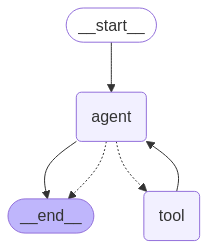

In [3]:
# Define tool schema
class PurchaseTicketInput(BaseModel):
    destination: str = Field(..., description="The destination of the plane ticket.")
    
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4",
    temperature=0
)

# Create the tool
@tool(args_schema=PurchaseTicketInput)
def purchase_ticket(destination: str) -> str:
    """Buy a plane ticket for a given destination."""
    return f"Purchased ticket to {destination}"

tools = [purchase_ticket]
llm_with_tools = llm.bind_tools(tools)
node_tool = ToolNode(tools=tools)

# Define state type
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    ask_human_use_credit_card: bool

# Define agent node with tools
def node_agent(state: State):
    messages = state["messages"]
    result = llm_with_tools.invoke(messages)  # Simple invoke without tools
    return {"messages": [result]}

def should_continue(state: State):
    messages = state["messages"]
    ai_message = messages[-1]
    
    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END
    
# Create and configure the graph
workflow = StateGraph(State)
workflow.add_node("agent", node_agent)
workflow.add_node("tool", node_tool)

workflow.add_edge(START, "agent")
workflow.add_edge("tool", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tool": "tool",
        END: END
    }
)

workflow.add_edge("agent", END)

# Initialize memory checkpointer
checkpointer = MemorySaver()

# Compile the graph
graph = workflow.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
user_input = "I want to go to Tokyo"
def stream_graph_updates(user_input: str):
    input_message = {
        "messages": [
            SystemMessage(content="You are a helpful travel assistant that can book plane tickets."),
            HumanMessage(content=user_input)
        ],
        "ask_human_use_credit_card": False
    }
    
    config = {
        "configurable": {"thread_id": "t1"},
        "checkpoint_ns": "travel_agent",  # Name space for related interactions
        "checkpoint_id": "request"        
    }
    result = graph.invoke(input_message, config)

    # Check state for credit card authorization
    print("\nWAIT: We need human authorization for this operation.")
    user_input = input("Type 'yes' to allow credit card use: ").lower().strip()

    # Update state with user authorization
    current_state = graph.get_state(config)
    new_state = {
        "messages": current_state.values["messages"],
        "ask_human_use_credit_card": user_input == "yes"
    }

    if user_input == "yes":
        final_result = graph.invoke(new_state, config)
        print("\nFinal Result:", final_result["messages"][-1].content)
    else:
        print("\nOperation cancelled: Credit card authorization denied.")
            
while True:
    user_input = input("Enter Travel Plans: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)



WAIT: We need human authorization for this operation.

Final Result: I have successfully booked your plane ticket to Tokyo. Enjoy your trip!
Goodbye!
